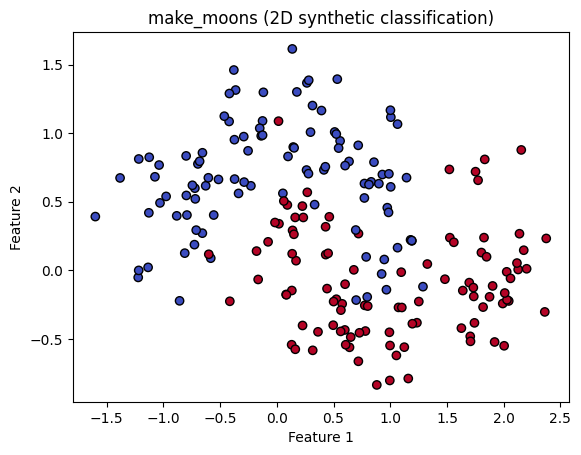

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Генерируем полумесяцы
X, y = make_moons(n_samples=200, noise=0.25, random_state=42)

# Визуализация
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("make_moons (2D synthetic classification)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [2]:
import numpy as np

In [3]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None,right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

In [20]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=10, min_samples_split=2): # min_samples_split: минимальное количество объектов, чтобы делить узел
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y): # Точка входа в построение. Вызов _grow_tree возвращает корень дерева (объект Node), хранящийся в self.root.
        self.root = self._grow_tree(X, y)
        
        
    def predict(self, X): # Для каждого объекта x мы идём по дереву от корня (self.root), пока не придём к листу — и возвращаем его value.
        return np.array([self._predict_sample(x, self.root) for x in X])
        
        
    def _predict_sample(self, x, node): # Рекурсивный спуск по дереву
        if node.is_leaf():
            return node.value
        if x[node.feature] < node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
            

    def _gini(self, y):
        proportions = [np.sum(y==c)/len(y) for c in np.unique(y)]
        return 1 - sum(p**2 for p in proportions)
        
        
    def _most_common_label(self, y): # Выбираем класс, который встречается чаще всего — это будет предсказание для "листа"
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]
        

    def _information_gain(self, y, feature_column, threshold):
        parent_impurity = self._gini(y)

        left_mask = feature_column < threshold
        right_mask = ~left_mask

        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0

        n = len(y)
        n_l, n_r = np.sum(left_mask), np.sum(right_mask)

        e_l = self._gini(y[left_mask])
        e_r = self._gini(y[right_mask])

        child_impurity = (n_l/n) * e_l + (n_r/n)* e_r

        return parent_impurity - child_impurity
        

    def _best_split(self, X, y, n_features):
        """
        Перебирает все признаки
        Перебирает все уникальные значения как возможные пороги
        Выбирает то, где максимум прироста информации
        """
        best_gain = -1
        split_idx, split_thresh = None, None
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                gain = self._information_gain(y, X[:, feature], t)
                if gain > best_gain:
                    best_gain = gain
                    split_idx, split_thresh = feature, t
        return split_idx, split_thresh    
        
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Условия остановки
        """
        достигли макс. глубины
        все метки одинаковые
        мало объектов → нет смысла делить
        """
        if (depth >= self.max_depth) or (n_labels == 1) or (n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Поиск лучшего разделения
        best_feature, best_threshold = self._best_split(X, y, n_features)

        if best_feature is None:
            return Node(value=self._most_common_label(y))

        # Делим узел
        left_idxs = X[:, best_feature] < best_threshold
        right_idxs = ~left_idxs
        # ⛔ Проверка: если одно из подмножеств пустое — остановиться
        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
            return Node(value=self._most_common_label(y))
        # Создаём подмножества. Рекурсивно строим дерево по ним:
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth+1)
        return Node(best_feature, best_threshold, left, right)
        

In [22]:
def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


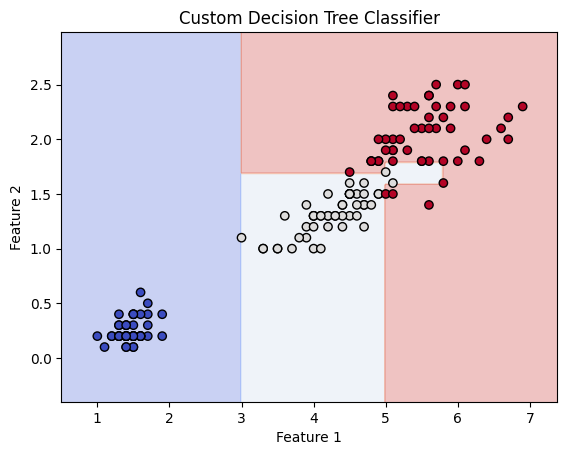

In [23]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X, y)

plot_decision_boundary(tree, X, y, "Custom Decision Tree Classifier")


# Comparing to sklearn

In [24]:
from sklearn.tree import DecisionTreeClassifier as SklearnTree

# Твоя модель
my_tree = DecisionTreeClassifier(max_depth=5)
my_tree.fit(X, y)

# Sklearn-модель
sk_tree = SklearnTree(max_depth=5)
sk_tree.fit(X, y)


DecisionTreeClassifier(max_depth=5)

In [25]:
def plot_comparison(my_model, sk_model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Предсказания
    Z_my = my_model.predict(grid).reshape(xx.shape)
    Z_sk = sk_model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(12, 5))

    # Твоя модель
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z_my, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title("Моя Decision Tree")

    # Sklearn модель
    plt.subplot(1, 2, 2)
    plt.contourf(xx, yy, Z_sk, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title("Sklearn Decision Tree")

    plt.tight_layout()
    plt.show()


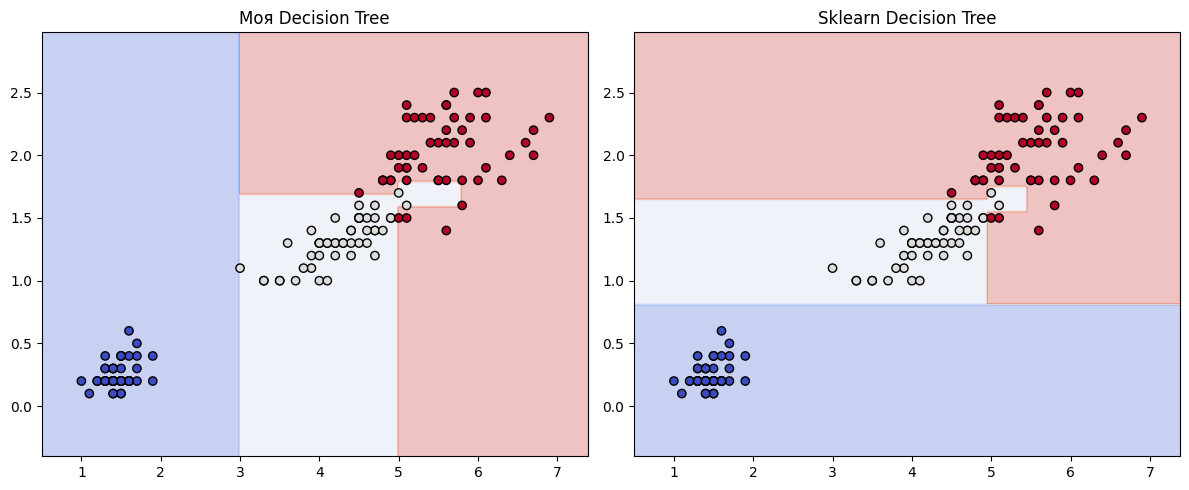

In [26]:
plot_comparison(my_tree, sk_tree, X, y)


# Iris

In [27]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Загружаем только 2 признака: длина и ширина лепестка
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [28]:
# Моя модель
my_tree = DecisionTreeClassifier(max_depth=5)
my_tree.fit(X_train, y_train)

# Sklearn
from sklearn.tree import DecisionTreeClassifier as SkTree
sk_tree = SkTree(max_depth=5)
sk_tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

In [31]:
def plot_iris_comparison(my_model, sk_model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z_my = my_model.predict(grid).reshape(xx.shape)
    Z_sk = sk_model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z_my, alpha=0.3, cmap='Accent')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Accent', edgecolor='k')
    plt.title("Моя Decision Tree (Iris)")

    plt.subplot(1, 2, 2)
    plt.contourf(xx, yy, Z_sk, alpha=0.3, cmap='Accent')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Accent', edgecolor='k')
    plt.title("Sklearn Decision Tree (Iris)")

    plt.tight_layout()
    plt.show()


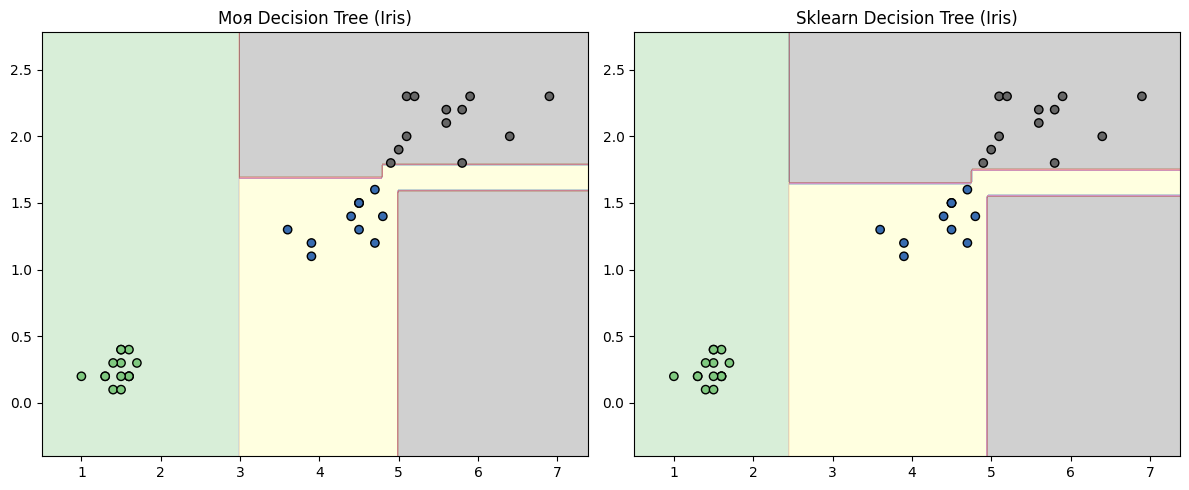

In [32]:
plot_iris_comparison(my_tree, sk_tree, X_test, y_test)


In [35]:
from sklearn.metrics import accuracy_score

y_pred_my = my_tree.predict(X_test)
y_pred_sk = sk_tree.predict(X_test)

print("Точность моей модели:", accuracy_score(y_test, y_pred_my))
print("Точность sklearn модели:", accuracy_score(y_test, y_pred_sk))


Точность моей модели: 1.0
Точность sklearn модели: 1.0


# Обработка пропусков и категориальных признаков

In [38]:
import pandas as pd

In [41]:
import numpy as np
from collections import Counter

# ---------- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ----------
def _most_common_label(y):
    return Counter(y).most_common(1)[0][0]

def _gini(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

# ---------- СТРУКТУРА УЗЛА ----------
class Node:
    def __init__(self, *,      # только именные арг‑ты для наглядности
                 feature        = None,
                 threshold      = None,   # для числовых
                 category       = None,   # для категориальных
                 left           = None,
                 right          = None,
                 value          = None):  # если лист
        self.feature   = feature
        self.threshold = threshold
        self.category  = category
        self.left      = left
        self.right     = right
        self.value     = value

    def is_leaf(self):
        return self.value is not None


# ---------- ДЕРЕВО ----------
class DecisionTreeClassifier:
    def __init__(self,
                 max_depth         = 10,
                 min_samples_split = 2,
                 nan_policy        = "mean"):  # median / most_frequent
        self.max_depth         = max_depth
        self.min_samples_split = min_samples_split
        self.nan_policy        = nan_policy

    # ——— fit ———
    def fit(self, X, y):
        X = X.copy()  # не портим оригинал
        self._detect_feature_types(X)
        self._impute_nans(X)     # простейшая импутация
        self.root = self._grow(X, y, depth=0)

    # ——— predict ———
    def predict(self, X):
        X = X.copy()
        self._impute_nans(X, train=False)
        return np.array([self._traverse(x, self.root) for x in X])

    # ——— PRIVATE ———
    def _detect_feature_types(self, X):
        """Определяем, какая колонка числовая, а какая категориальная."""
        self.feature_types = []
        for col in X.T:
            if np.issubdtype(col.dtype, np.number):
                self.feature_types.append("numerical")
            else:
                self.feature_types.append("categorical")

    # ---- импутация NaN ----
    def _impute_nans(self, X, train=True):
        if train:
            self.fill_ = []
            for j, col in enumerate(X.T):
                col = np.array(col)
                # Фильтруем только непустые значения
                non_missing = col[~pd.isna(col)]
    
                if self.feature_types[j] == "numerical":
                    fill_val = np.mean(non_missing.astype(float))
                else:  # категор.
                    vals, cnts = np.unique(non_missing, return_counts=True)
                    fill_val = vals[np.argmax(cnts)]
    
                self.fill_.append(fill_val)
    
        # Применяем заполнение
        for j, fill_val in enumerate(self.fill_):
            col = X[:, j]
            mask = pd.isna(col)
            X[mask, j] = fill_val

    # ---- рекурсивный рост ----
    def _grow(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or
            n_labels == 1 or
            n_samples < self.min_samples_split):
            return Node(value=_most_common_label(y))

        best_feat, best_thr, best_cat, best_gain = None, None, None, -np.inf

        # перебираем признаки
        for j in range(n_features):
            if self.feature_types[j] == "numerical":
                thresholds = np.unique(X[:, j])
                for thr in thresholds:
                    gain = self._info_gain_num(X[:, j], y, thr)
                    if gain > best_gain:
                        best_feat, best_thr, best_cat = j, thr, None
                        best_gain = gain
            else:  # categorical
                categories = np.unique(X[:, j])
                for cat in categories:
                    gain = self._info_gain_cat(X[:, j], y, cat)
                    if gain > best_gain:
                        best_feat, best_thr = j, None
                        best_cat  = cat
                        best_gain = gain

        if best_gain == -np.inf:  # split не найден
            return Node(value=_most_common_label(y))

        # разделяем
        if best_cat is None:  # числовой split
            left_mask  = X[:, best_feat] < best_thr
        else:                 # категориальный
            left_mask  = X[:, best_feat] == best_cat
        right_mask = ~left_mask

        # если одно из подмножеств пустое – лист
        if right_mask.sum() == 0 or left_mask.sum() == 0:
            return Node(value=_most_common_label(y))

        left  = self._grow(X[left_mask],  y[left_mask],  depth + 1)
        right = self._grow(X[right_mask], y[right_mask], depth + 1)

        return Node(feature=best_feat,
                    threshold=best_thr,
                    category =best_cat,
                    left=left,
                    right=right)

    # ---- impurity и gain ----
    def _info_gain_num(self, col, y, thr):
        parent = _gini(y)
        left_mask  = col < thr
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return -np.inf
        n = len(y)
        n_l, n_r = left_mask.sum(), right_mask.sum()
        child = (n_l/n)*_gini(y[left_mask]) + (n_r/n)*_gini(y[right_mask])
        return parent - child

    def _info_gain_cat(self, col, y, cat):
        parent = _gini(y)
        left_mask  = col == cat
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return -np.inf
        n = len(y)
        n_l, n_r = left_mask.sum(), right_mask.sum()
        child = (n_l/n)*_gini(y[left_mask]) + (n_r/n)*_gini(y[right_mask])
        return parent - child

    # ---- обход при предсказании ----
    def _traverse(self, x, node):
        if node.is_leaf():
            return node.value
        feat = node.feature
        if self.feature_types[feat] == "numerical":
            if x[feat] < node.threshold:
                return self._traverse(x, node.left)
            else:
                return self._traverse(x, node.right)
        else:  # categorical
            if x[feat] == node.category:
                return self._traverse(x, node.left)
            else:
                return self._traverse(x, node.right)


In [42]:
import numpy as np
X = np.array([
    [5.1, 'Red'],
    [4.9, 'Blue'],
    [6.2, 'Red'],
    [5.0, np.nan],   # NaN будет заимпутирован
], dtype=object)

y = np.array([0, 1, 0, 1])

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X, y)
print(tree.predict(X))


[0 1 0 1]


# DataFrame and Visualization

In [45]:
import numpy as np
from collections import Counter

# ---------- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ----------
def _most_common_label(y):
    return Counter(y).most_common(1)[0][0]

def _gini(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

# ---------- СТРУКТУРА УЗЛА ----------
class Node:
    def __init__(self, *,      # только именные арг‑ты для наглядности
                 feature        = None,
                 threshold      = None,   # для числовых
                 category       = None,   # для категориальных
                 left           = None,
                 right          = None,
                 value          = None):  # если лист
        self.feature   = feature
        self.threshold = threshold
        self.category  = category
        self.left      = left
        self.right     = right
        self.value     = value

    def is_leaf(self):
        return self.value is not None


# ---------- ДЕРЕВО ----------
class DecisionTreeClassifier:
    def __init__(self,
                 max_depth         = 10,
                 min_samples_split = 2,
                 nan_policy        = "mean"):  # median / most_frequent
        self.max_depth         = max_depth
        self.min_samples_split = min_samples_split
        self.nan_policy        = nan_policy

    # ——— fit ———
    def fit(self, X, y):
        y = np.array(y) 
        X = X.copy()
        self._detect_feature_types(X)
        self._impute_nans(self.X_)
        self.root = self._grow(self.X_, y, depth=0)



    # ——— predict ———
    def predict(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            X = X.values
        self._impute_nans(X, train=False)
        return np.array([self._traverse(x, self.root) for x in X])

    # ——— PRIVATE ———
    def _detect_feature_types(self, X):
        """Определяем тип каждого признака: числовой или категориальный."""
        self.feature_types = []
    
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
            for dtype in X.dtypes:
                if pd.api.types.is_numeric_dtype(dtype):
                    self.feature_types.append("numerical")
                else:
                    self.feature_types.append("categorical")
            self.X_ = X.values  # сохраняем numpy
        else:
            self.feature_names = [f"x{i}" for i in range(X.shape[1])]
            self.X_ = X
            for col in X.T:
                if np.issubdtype(col.dtype, np.number):
                    self.feature_types.append("numerical")
                else:
                    self.feature_types.append("categorical")

    # ---- импутация NaN ----
    def _impute_nans(self, X, train=True):
        if train:
            self.fill_ = []
            for j, col in enumerate(X.T):
                col = np.array(col)
                # Фильтруем только непустые значения
                non_missing = col[~pd.isna(col)]
    
                if self.feature_types[j] == "numerical":
                    fill_val = np.mean(non_missing.astype(float))
                else:  # категор.
                    vals, cnts = np.unique(non_missing, return_counts=True)
                    fill_val = vals[np.argmax(cnts)]
    
                self.fill_.append(fill_val)
    
        # Применяем заполнение
        for j, fill_val in enumerate(self.fill_):
            col = X[:, j]
            mask = pd.isna(col)
            X[mask, j] = fill_val

    # ---- рекурсивный рост ----
    def _grow(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or
            n_labels == 1 or
            n_samples < self.min_samples_split):
            return Node(value=_most_common_label(y))

        best_feat, best_thr, best_cat, best_gain = None, None, None, -np.inf

        # перебираем признаки
        for j in range(n_features):
            if self.feature_types[j] == "numerical":
                thresholds = np.unique(X[:, j])
                for thr in thresholds:
                    gain = self._info_gain_num(X[:, j], y, thr)
                    if gain > best_gain:
                        best_feat, best_thr, best_cat = j, thr, None
                        best_gain = gain
            else:  # categorical
                categories = np.unique(X[:, j])
                for cat in categories:
                    gain = self._info_gain_cat(X[:, j], y, cat)
                    if gain > best_gain:
                        best_feat, best_thr = j, None
                        best_cat  = cat
                        best_gain = gain

        if best_gain == -np.inf:  # split не найден
            return Node(value=_most_common_label(y))

        # разделяем
        if best_cat is None:  # числовой split
            left_mask  = X[:, best_feat] < best_thr
        else:                 # категориальный
            left_mask  = X[:, best_feat] == best_cat
        right_mask = ~left_mask

        # если одно из подмножеств пустое – лист
        if right_mask.sum() == 0 or left_mask.sum() == 0:
            return Node(value=_most_common_label(y))

        left  = self._grow(X[left_mask],  y[left_mask],  depth + 1)
        right = self._grow(X[right_mask], y[right_mask], depth + 1)

        return Node(feature=best_feat,
                    threshold=best_thr,
                    category =best_cat,
                    left=left,
                    right=right)

    # ---- impurity и gain ----
    def _info_gain_num(self, col, y, thr):
        parent = _gini(y)
        left_mask  = col < thr
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return -np.inf
        n = len(y)
        n_l, n_r = left_mask.sum(), right_mask.sum()
        child = (n_l/n)*_gini(y[left_mask]) + (n_r/n)*_gini(y[right_mask])
        return parent - child

    def _info_gain_cat(self, col, y, cat):
        parent = _gini(y)
        left_mask  = col == cat
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return -np.inf
        n = len(y)
        n_l, n_r = left_mask.sum(), right_mask.sum()
        child = (n_l/n)*_gini(y[left_mask]) + (n_r/n)*_gini(y[right_mask])
        return parent - child

    # ---- обход при предсказании ----
    def _traverse(self, x, node):
        if node.is_leaf():
            return node.value
        feat = node.feature
        if self.feature_types[feat] == "numerical":
            if x[feat] < node.threshold:
                return self._traverse(x, node.left)
            else:
                return self._traverse(x, node.right)
        else:  # categorical
            if x[feat] == node.category:
                return self._traverse(x, node.left)
            else:
                return self._traverse(x, node.right)

    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root
    
        indent = "  " * depth
    
        if node.is_leaf():
            print(f"{indent}Predict → {node.value}")
            return
    
        feat_name = self.feature_names[node.feature] if hasattr(self, 'feature_names') else f"x{node.feature}"
    
        if self.feature_types[node.feature] == "numerical":
            print(f"{indent}if {feat_name} < {node.threshold:.3f}:")
            self.print_tree(node.left, depth + 1)
            print(f"{indent}else:")
            self.print_tree(node.right, depth + 1)
        else:
            print(f"{indent}if {feat_name} == '{node.category}':")
            self.print_tree(node.left, depth + 1)
            print(f"{indent}else:")
            self.print_tree(node.right, depth + 1)


In [48]:
import pandas as pd

data = pd.DataFrame({
    'Temperature': [20.1, 22.3, 21.8, 19.5],
    'Color': ['Red', 'Blue', 'Red', None]
})
target = [1, 0, 1, 0]

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(data, target)
print(tree.predict(data))
tree.print_tree()


[1 0 1 0]
if Temperature < 20.100:
  Predict → 0
else:
  if Temperature < 22.300:
    Predict → 1
  else:
    Predict → 0


# Adding feature importance

In [51]:
import numpy as np
from collections import Counter

# ---------- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ----------
def _most_common_label(y):
    return Counter(y).most_common(1)[0][0]

def _gini(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

# ---------- СТРУКТУРА УЗЛА ----------
class Node:
    def __init__(self, *,      # только именные арг‑ты для наглядности
                 feature        = None,
                 threshold      = None,   # для числовых
                 category       = None,   # для категориальных
                 left           = None,
                 right          = None,
                 value          = None):  # если лист
        self.feature   = feature
        self.threshold = threshold
        self.category  = category
        self.left      = left
        self.right     = right
        self.value     = value

    def is_leaf(self):
        return self.value is not None


# ---------- ДЕРЕВО ----------
class DecisionTreeClassifier:
    def __init__(self,
                 max_depth         = 10,
                 min_samples_split = 2,
                 nan_policy        = "mean"):  # median / most_frequent
        self.max_depth         = max_depth
        self.min_samples_split = min_samples_split
        self.nan_policy        = nan_policy

    # ——— fit ———
    def fit(self, X, y):
        y = np.array(y)
        self.n_samples_ = len(y)
        X = X.copy()
        self._detect_feature_types(X)
        self._impute_nans(self.X_)
        self.root = self._grow(self.X_, y, depth=0)



    # ——— predict ———
    def predict(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            X = X.values
        self._impute_nans(X, train=False)
        return np.array([self._traverse(x, self.root) for x in X])

    # ——— PRIVATE ———
    def _detect_feature_types(self, X):
        """Определяем тип каждого признака: числовой или категориальный."""
        self.feature_types = []
    
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
            for dtype in X.dtypes:
                if pd.api.types.is_numeric_dtype(dtype):
                    self.feature_types.append("numerical")
                else:
                    self.feature_types.append("categorical")
            self.X_ = X.values  # сохраняем numpy
        else:
            self.feature_names = [f"x{i}" for i in range(X.shape[1])]
            self.X_ = X
            for col in X.T:
                if np.issubdtype(col.dtype, np.number):
                    self.feature_types.append("numerical")
                else:
                    self.feature_types.append("categorical")

    # ---- импутация NaN ----
    def _impute_nans(self, X, train=True):
        if train:
            self.fill_ = []
            for j, col in enumerate(X.T):
                col = np.array(col)
                # Фильтруем только непустые значения
                non_missing = col[~pd.isna(col)]
    
                if self.feature_types[j] == "numerical":
                    fill_val = np.mean(non_missing.astype(float))
                else:  # категор.
                    vals, cnts = np.unique(non_missing, return_counts=True)
                    fill_val = vals[np.argmax(cnts)]
    
                self.fill_.append(fill_val)
    
        # Применяем заполнение
        for j, fill_val in enumerate(self.fill_):
            col = X[:, j]
            mask = pd.isna(col)
            X[mask, j] = fill_val

    # ---- рекурсивный рост ----
    def _grow(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf = Node(value=_most_common_label(y))
            leaf.n_samples = len(y)
            leaf.impurity = _gini(y)  # или entropy
            return leaf

        best_feat, best_thr, best_cat, best_gain = None, None, None, -np.inf

        # перебираем признаки
        for j in range(n_features):
            if self.feature_types[j] == "numerical":
                thresholds = np.unique(X[:, j])
                for thr in thresholds:
                    gain = self._info_gain_num(X[:, j], y, thr)
                    if gain > best_gain:
                        best_feat, best_thr, best_cat = j, thr, None
                        best_gain = gain
            else:  # categorical
                categories = np.unique(X[:, j])
                for cat in categories:
                    gain = self._info_gain_cat(X[:, j], y, cat)
                    if gain > best_gain:
                        best_feat, best_thr = j, None
                        best_cat  = cat
                        best_gain = gain

        if best_gain == -np.inf:  # split не найден
            return Node(value=_most_common_label(y))

        # разделяем
        if best_cat is None:  # числовой split
            left_mask  = X[:, best_feat] < best_thr
        else:                 # категориальный
            left_mask  = X[:, best_feat] == best_cat
        right_mask = ~left_mask

        # если одно из подмножеств пустое – лист
        if right_mask.sum() == 0 or left_mask.sum() == 0:
            return Node(value=_most_common_label(y))

        left  = self._grow(X[left_mask],  y[left_mask],  depth + 1)
        right = self._grow(X[right_mask], y[right_mask], depth + 1)

        impurity = _gini(y)
        node = Node(feature=best_feat,
                    threshold=best_thr,
                    category =best_cat,
                    left=left,
                    right=right)
        node.n_samples = len(y)
        node.impurity = impurity
        return node

    # ---- impurity и gain ----
    def _info_gain_num(self, col, y, thr):
        parent = _gini(y)
        left_mask  = col < thr
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return -np.inf
        n = len(y)
        n_l, n_r = left_mask.sum(), right_mask.sum()
        child = (n_l/n)*_gini(y[left_mask]) + (n_r/n)*_gini(y[right_mask])
        return parent - child

    def _info_gain_cat(self, col, y, cat):
        parent = _gini(y)
        left_mask  = col == cat
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return -np.inf
        n = len(y)
        n_l, n_r = left_mask.sum(), right_mask.sum()
        child = (n_l/n)*_gini(y[left_mask]) + (n_r/n)*_gini(y[right_mask])
        return parent - child

    # ---- обход при предсказании ----
    def _traverse(self, x, node):
        if node.is_leaf():
            return node.value
        feat = node.feature
        if self.feature_types[feat] == "numerical":
            if x[feat] < node.threshold:
                return self._traverse(x, node.left)
            else:
                return self._traverse(x, node.right)
        else:  # categorical
            if x[feat] == node.category:
                return self._traverse(x, node.left)
            else:
                return self._traverse(x, node.right)

    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root
    
        indent = "  " * depth
    
        if node.is_leaf():
            print(f"{indent}Predict → {node.value}")
            return
    
        feat_name = self.feature_names[node.feature] if hasattr(self, 'feature_names') else f"x{node.feature}"
    
        if self.feature_types[node.feature] == "numerical":
            print(f"{indent}if {feat_name} < {node.threshold:.3f}:")
            self.print_tree(node.left, depth + 1)
            print(f"{indent}else:")
            self.print_tree(node.right, depth + 1)
        else:
            print(f"{indent}if {feat_name} == '{node.category}':")
            self.print_tree(node.left, depth + 1)
            print(f"{indent}else:")
            self.print_tree(node.right, depth + 1)

    def feature_importances(self):
        importances = np.zeros(len(self.feature_types))
        self._compute_importances(self.root, importances, total_samples=self.n_samples_)
        return dict(zip(self.feature_names, importances / importances.sum()))

    def _compute_importances(self, node, importances, total_samples):
        if node.is_leaf():
            return
    
        n = node.n_samples
        impurity_parent = node.impurity
    
        # Левые/правые узлы
        left, right = node.left, node.right
        n_l, n_r = left.n_samples, right.n_samples
        imp_l, imp_r = left.impurity, right.impurity
    
        # Gain
        impurity_decrease = impurity_parent - (n_l / n) * imp_l - (n_r / n) * imp_r
    
        importances[node.feature] += impurity_decrease * (n / total_samples)
    
        self._compute_importances(left, importances, total_samples)
        self._compute_importances(right, importances, total_samples)
    


In [52]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(data, target)

print(tree.feature_importances())


{'Temperature': 1.0, 'Color': 0.0}


# Дерево для Регрессии

In [53]:
class RegressionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        self.root = self._grow_tree(self.X, self.y, depth=0)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._traverse(x, self.root) for x in X])

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _best_split(self, X, y):
        best_feature, best_threshold, best_mse = None, None, float('inf')
        n_samples, n_features = X.shape

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] < threshold
                right_mask = ~left_mask
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue

                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                mse_total = (len(y[left_mask]) * mse_left + len(y[right_mask]) * mse_right) / len(y)

                if mse_total < best_mse:
                    best_feature = feature
                    best_threshold = threshold
                    best_mse = mse_total

        return best_feature, best_threshold

    def _grow_tree(self, X, y, depth):
        if (depth >= self.max_depth) or (len(y) < self.min_samples_split):
            return self.Node(value=np.mean(y))

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return self.Node(value=np.mean(y))

        left_mask = X[:, feature] < threshold
        right_mask = ~left_mask

        left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        return self.Node(feature, threshold, left, right)

    def _traverse(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self._traverse(x, node.left)
        else:
            return self._traverse(x, node.right)


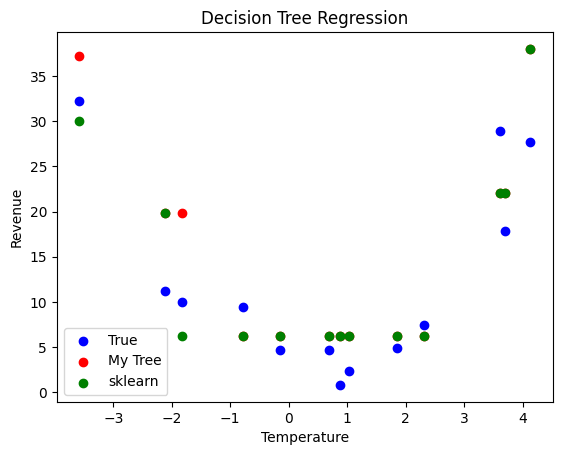

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Ice Cream Data
df = pd.read_csv("Ice_cream selling data.csv")  # Должен содержать Temperature, Revenue

X = df[['Temperature (°C)']].values
y = df['Ice Cream Sales (units)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tree = RegressionTree(max_depth=3)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

# Сравнение со sklearn
from sklearn.tree import DecisionTreeRegressor
sk_tree = DecisionTreeRegressor(max_depth=3)
sk_tree.fit(X_train, y_train)
sk_pred = sk_tree.predict(X_test)

# Визуализация
plt.scatter(X_test, y_test, color='blue', label='True')
plt.scatter(X_test, y_pred, color='red', label='My Tree')
plt.scatter(X_test, sk_pred, color='green', label='sklearn')
plt.xlabel("Temperature")
plt.ylabel("Revenue")
plt.legend()
plt.title("Decision Tree Regression")
plt.show()


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Предсказания
my_pred = tree.predict(X_test)
sk_pred = sk_tree.predict(X_test)

# MAE
mae_my = mean_absolute_error(y_test, my_pred)
mae_sk = mean_absolute_error(y_test, sk_pred)

# MSE
mse_my = mean_squared_error(y_test, my_pred)
mse_sk = mean_squared_error(y_test, sk_pred)

# R^2
r2_my = r2_score(y_test, my_pred)
r2_sk = r2_score(y_test, sk_pred)

# Вывод
print(f"MAE (my):     {mae_my:.4f}")
print(f"MAE (sklearn):{mae_sk:.4f}\n")

print(f"MSE (my):     {mse_my:.4f}")
print(f"MSE (sklearn):{mse_sk:.4f}\n")

print(f"R2  (my):     {r2_my:.4f}")
print(f"R2  (sklearn):{r2_sk:.4f}")


MAE (my):     4.8485
MAE (sklearn):4.1809

MSE (my):     33.0122
MSE (sklearn):25.2471

R2  (my):     0.6904
R2  (sklearn):0.7632


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

my_preds = tree.predict(X_test)
sk_preds = sk_tree.predict(X_test)

# Метрики
print("---- My Tree ----")
print("MAE :", mean_absolute_error(y_test, my_preds))
print("MSE :", mean_squared_error(y_test, my_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, my_preds)))
print("R²  :", r2_score(y_test, my_preds))

print("\n---- Sklearn Tree ----")
print("MAE :", mean_absolute_error(y_test, sk_preds))
print("MSE :", mean_squared_error(y_test, sk_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, sk_preds)))
print("R²  :", r2_score(y_test, sk_preds))


---- My Tree ----
MAE : 4.848502750995501
MSE : 33.01223803225861
RMSE: 5.745627731785153
R²  : 0.6904125667839868

---- Sklearn Tree ----
MAE : 4.180918576578374
MSE : 25.24710049758774
RMSE: 5.024649291004073
R²  : 0.763233712553594


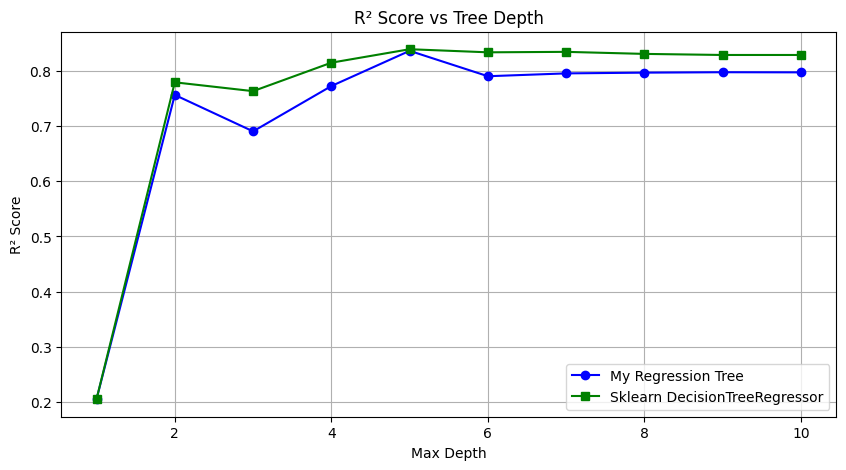

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

max_depths = range(1, 11)
my_scores = []
sk_scores = []

for depth in max_depths:
    # Твоя модель
    my_tree = RegressionTree(max_depth=depth)
    my_tree.fit(X_train, y_train)
    my_preds = my_tree.predict(X_test)
    my_scores.append(r2_score(y_test, my_preds))

    # Sklearn модель
    sk_tree = DecisionTreeRegressor(max_depth=depth)
    sk_tree.fit(X_train, y_train)
    sk_preds = sk_tree.predict(X_test)
    sk_scores.append(r2_score(y_test, sk_preds))

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(max_depths, my_scores, marker='o', label='My Regression Tree', color='blue')
plt.plot(max_depths, sk_scores, marker='s', label='Sklearn DecisionTreeRegressor', color='green')
plt.xlabel("Max Depth")
plt.ylabel("R² Score")
plt.title("R² Score vs Tree Depth")
plt.legend()
plt.grid(True)
plt.show()
